# Environment Setting

In [66]:
IN_COLAB = False

try:
  import google.colab
  IN_COLAB = True
except:
  pass

if IN_COLAB == True:
  from google.colab import drive
  drive.mount('/content/gdrive')
  %cd /content/gdrive/MyDrive/Tesi_GDrive
  PROJECT_PATH = '/content/gdrive/MyDrive/Tesi_GDrive'
  #!ls
else:
  %cd /Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive
  PROJECT_PATH = '/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive'

import warnings
import pickle
import sys
import os

if IN_COLAB == True:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))
else:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from keras.models import Sequential, Model
from keras.layers import Dense, Lambda
from keras.layers import Activation
from keras.activations import exponential, relu
from keras import backend as K
import tensorflow as tf
#from tensorflow.keras.layers import Input, Layer, InputSpec, Reshape
#from tensorflow.keras import initializers
#from tensorflow.keras.optimizers import Adam
tf.config.run_functions_eagerly(True)
from scipy.optimize import minimize, differential_evolution

#from pkl import store_data, load_data
#from functions.compressor import compress
from functions.compressor_param import compress_2
from functions.mapping import sub2ind, ind2sub


import random
from collections import defaultdict

import time



print("Libraries imported")

/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive
Libraries imported


## Data Loading

In [99]:
R_cluster_8 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_8/R_Cluster_8.npy'))
R_cluster_10 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_10/R_Cluster_10.npy'))
R_cluster_15 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_15/R_Cluster_15.npy'))
R_cluster_22 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_22/R_Cluster_22.npy'))
R_cluster_30 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_30/R_Cluster_30.npy'))

T_cluster_8 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_8/T_Cluster_8.npy'))
T_cluster_10 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_10/T_Cluster_10.npy'))
T_cluster_15 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_15/T_Cluster_15.npy'))
T_cluster_22 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_22/T_Cluster_22.npy'))
T_cluster_30 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_30/T_Cluster_30.npy'))

actions = np.load(os.path.join(PROJECT_PATH, 'MDP_data/actions.npy'))


In [96]:
T = T_cluster_8
R = R_cluster_8
print("T and R loaded")
print("T shape: ", T.shape)
print("R shape: ", R.shape)

T and R loaded
T shape:  (8, 8, 1600)
R shape:  (8, 1600)


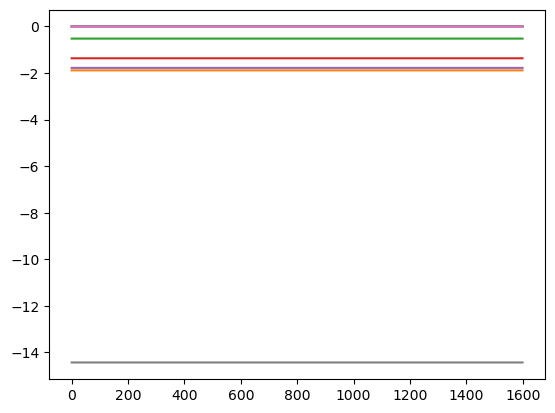

In [97]:
# plot R[i,:] per ogni cluster
for i in range(R.shape[0]):
    plt.plot(R[i,:])
plt.show()

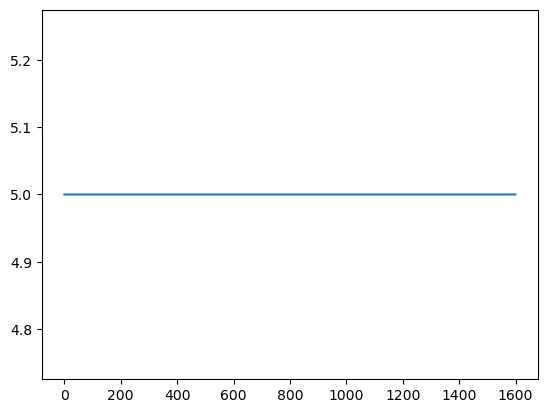

In [98]:
#plot the best action for each state
best_action = np.argmax(R, axis=0)
plt.plot(best_action)

In [109]:
best_action = ind2sub(actions.shape, 5)
print("best_action", best_action)
actions[best_action[0], best_action[1]]
print(actions.shape)

best_action (1, 2)
(1600, 3)


## Policy Iteration

In [62]:
def policy_evaluation(T, R, gamma, pi, v):
    S = T.shape[0]
    Ppi = np.zeros((S, S))
    Rpi = np.zeros((S,))

    for s in range(S):
        Ppi[s, :] = T[s, :, pi[s].astype(int)]
        Rpi[s] = R[s, pi[s].astype(int)]
    
    while True:
        vprec = v
        v = Rpi + gamma * np.dot(Ppi, vprec)
        if np.linalg.norm(v - vprec, np.inf) < 1e-6:
            print("p_eval convergenza raggiunta")
            break
    
    return v

In [63]:
def policy_improvement(T, R, gamma, value):
    S = T.shape[0]
    A = T.shape[1]
    
    pip = np.zeros((S, 1))

    for s in range(S):
        q = np.zeros((A, 1))
        for a in range(A):
            trans = T[s, :, a]
    
            q[a] = R[s,a] + gamma*np.dot(trans, value)
        pip[s] = np.argmax(q)
    
    return pip

In [65]:
def policy_iteration(T, R, gamma):
    S = T.shape[0]
    A = T.shape[1]
    
    policy = np.random.randint(A, size=S)
    value = np.zeros(S)
    oldpolicy = policy
    
    while True:
        value = policy_evaluation(T, R, gamma, policy, value)
        policy = policy_improvement(T, R, gamma, value)
        if np.linalg.norm(policy - oldpolicy, np.inf) == 0:
            print("p_iteration convergenza raggiunta")
            break
        oldpolicy = policy
    
    return policy, value

gamma = 0.99
policy, value = policy_iteration(T, R, gamma)

KeyboardInterrupt: 

## Value Iteration

In [86]:
def policy_optim(T, R, gamma, value):
    S = T.shape[0]
    A = T.shape[1]

    new_value = np.zeros(S)
    policy = np.zeros(S)

    for s in range(S):
        q = np.zeros((A, 1))
        for a in range(A):
            trans = T[s, :, a]
            q[a] = R[s,a] + gamma* np.dot(trans,value)
        new_value[s] = np.max(q)
        policy[s] = np.argmax(q)
    
    return new_value, policy
    

In [89]:
def value_iteration(T, R, gamma):

    S = T.shape[0]
    A = T.shape[1]

    value = np.random.randint(A, size=(S, 1))
    prevpolicy = np.random.rand(S, 1)

    while True:
        value, policy = policy_optim(T, R, gamma, value)
        if np.linalg.norm(policy - prevpolicy, np.inf) == 0:
            print("v_iteration convergenza raggiunta")
            break
        prevpolicy = policy
    
    return policy, value
        
value_iteration(T, R, gamma)
policy, value

v_iteration convergenza raggiunta


(array([[2.],
        [5.],
        [1.],
        [1.],
        [6.],
        [1.],
        [6.],
        [0.]]),
 array([-4.22496359e-03, -1.90644825e+00, -5.50617792e-01, -1.37157894e+00,
        -1.78153769e+00, -3.83183757e-03, -1.42833071e-02, -1.44291523e+01]))

In [94]:
#plot value function and policy function for each state
def plot_value_function(V, P):
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    plt.plot(V)
    plt.title("Value function")
    plt.subplot(122)
    plt.plot(P)
    plt.title("Policy function")
    plt.show()
    

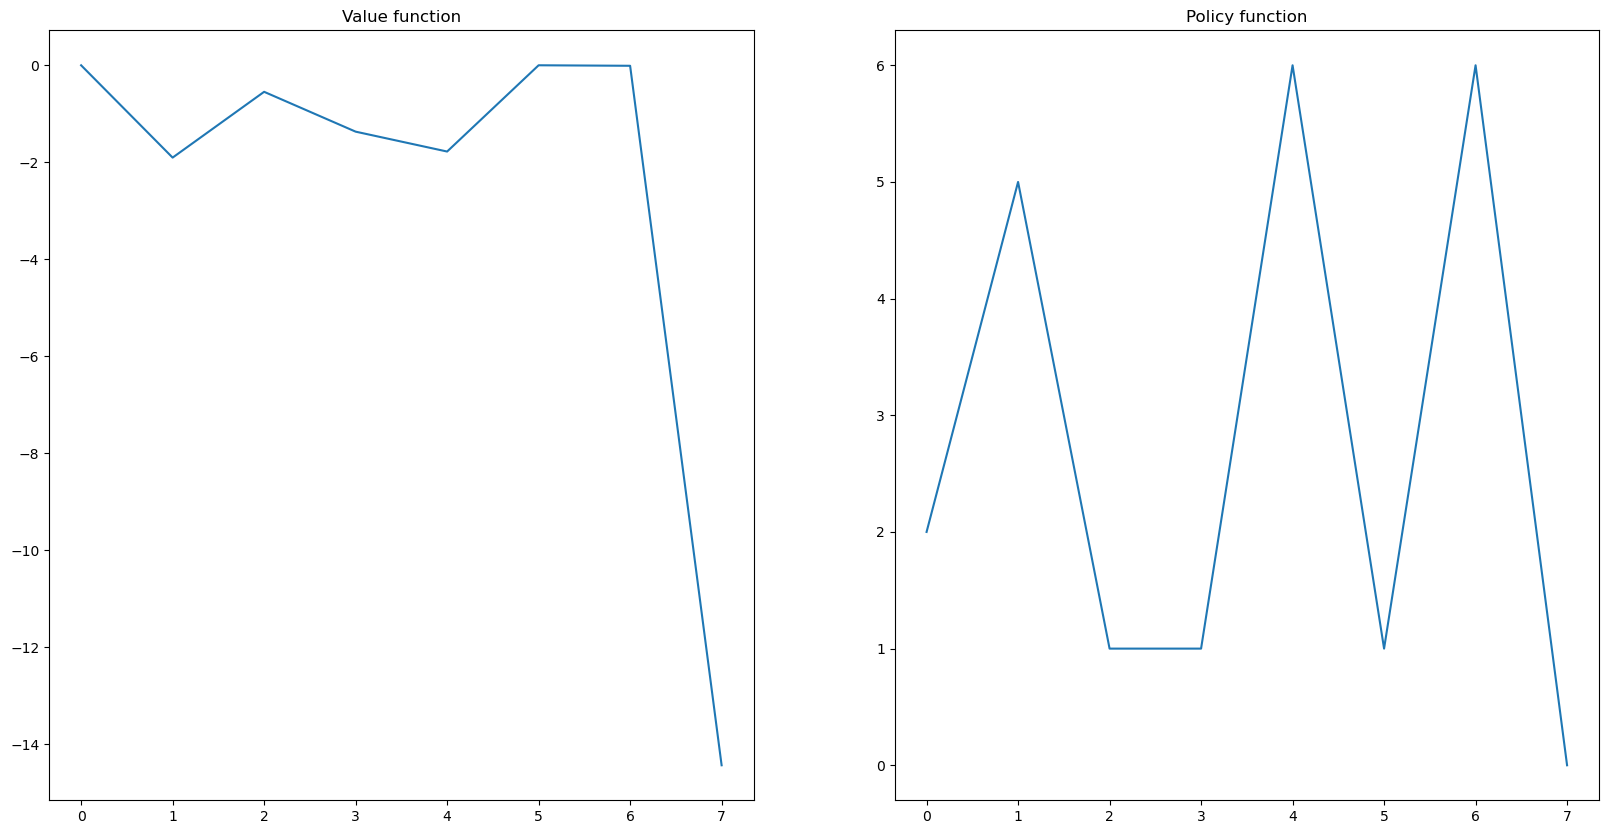

In [95]:
plot_value_function(value, policy)